# sommelier.ai

Practical machine learning workshop

### Tools and Documentation
- [Jupyter Lab](https://jupyterlab.readthedocs.io/en/stable/getting_started/overview.html)
- [pandas](https://pandas.pydata.org/pandas-docs/stable/api.html)
- [matplotlib](https://matplotlib.org/api/api_overview.html)
- [scikit-learn](http://scikit-learn.org/stable/index.html)

In [2]:
# These 'magics' alter the behavior of the Jupyter notebook
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

In [13]:
df = pd.read_csv('.\\data\\winemag-data.zip', keep_default_na=False)
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,US,This wine's aromas are vibrant and fruit forwa...,,91,29.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Baer 2014 Malbec (Columbia Valley (WA)),Malbec,Baer
1,US,If you're curious about California Grenache Bl...,Tourmaline,88,24.0,California,Santa Ynez Valley,Central Coast,,,Coghlan 2010 Tourmaline Grenache Blanc (Santa ...,Grenache Blanc,Coghlan
2,France,"While the acidity is intense, it is balanced b...",,84,15.0,Beaujolais,Beaujolais-Villages,,Roger Voss,@vossroger,Domaine de Roche Guillon 2013 Beaujolais-Vill...,Gamay,Domaine de Roche Guillon
3,France,Red fruits and a soft tannic profile give a re...,,88,17.0,Southwest France,Cahors,,Roger Voss,@vossroger,Domaine de Cause 2011 Malbec (Cahors),Malbec,Domaine de Cause
4,Spain,Shows true Priorat depth and minerality while ...,Balcons,90,60.0,Catalonia,Priorat,,Michael Schachner,@wineschach,Pinord 2004 Balcons Red (Priorat),Red Blend,Pinord


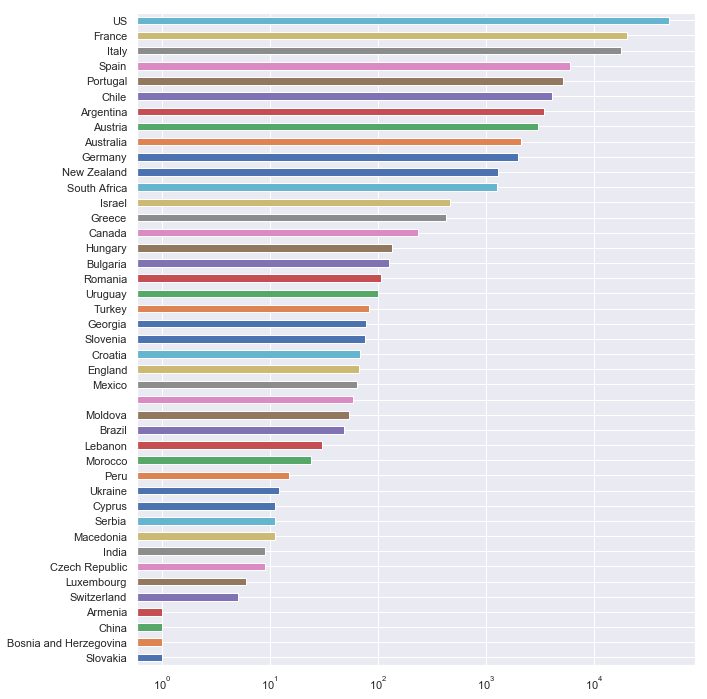

In [6]:
(df.country
   .value_counts(ascending=True)
   .plot.barh(figsize=(10,12), logx=True));

In [7]:
countries = (df.loc[df.country != '', 'country']
               .unique()
               .tolist())

countries_regex = '(' + '|'.join(countries) + ')'
countries_regex

'(US|France|Spain|Italy|Australia|Chile|Germany|Uruguay|Portugal|New Zealand|Israel|Argentina|Austria|Canada|South Africa|Greece|Turkey|Croatia|Hungary|Romania|India|Lebanon|Slovenia|England|Czech Republic|Bulgaria|Cyprus|Moldova|Georgia|Peru|Mexico|Brazil|Morocco|Ukraine|Bosnia and Herzegovina|Macedonia|Switzerland|Serbia|Luxembourg|China|Armenia|Slovakia)'

In [8]:
found_countries = (df.loc[df.country == '', 'description']
                     .str.extract(countries_regex)
                     .dropna())
found_countries

,0
215,South Africa
4152,Hungary
43890,Bulgaria
62502,Uruguay
63324,Switzerland
81016,Bulgaria
105248,Bulgaria


In [9]:
df.loc[found_countries.index, 'country'] = found_countries.values
df.loc[found_countries.index, 'country']

215       South Africa
4152           Hungary
43890         Bulgaria
62502          Uruguay
63324      Switzerland
81016         Bulgaria
105248        Bulgaria
Name: country, dtype: object

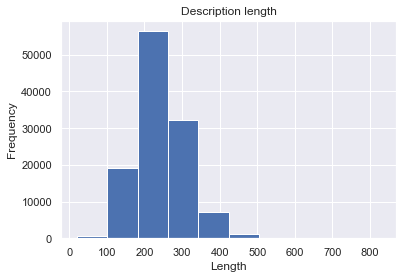

In [10]:
(df.description
   .str.len()
   .plot.hist(title='Description length')
   .set(xlabel="Length"));

In [163]:
df.groupby('taster_name')['points'].describe().sort_values('75%', ascending=False)

,count,mean,std,min,25%,50%,75%,max
taster_name,,,,,,,,
Anne Krebiehl MW,3311.0,90.569918,2.361676,80.0,89.0,90.0,92.0,97.0
Matt Kettmann,5690.0,90.000703,2.572281,81.0,88.0,90.0,92.0,97.0
Virginie Boone,8599.0,89.219212,2.999918,80.0,87.0,90.0,91.0,99.0
Sean P. Sullivan,4496.0,88.763345,2.461187,80.0,87.0,89.0,91.0,97.0
Roger Voss,23058.0,88.706740,3.037912,80.0,86.0,88.0,91.0,100.0
Paul Gregutt,8560.0,89.070561,2.826017,80.0,87.0,89.0,91.0,100.0
Jim Gordon,3784.0,88.611258,2.685918,80.0,87.0,89.0,91.0,97.0
Joe Czerwinski,4634.0,88.525248,2.856581,80.0,87.0,89.0,91.0,100.0
Lauren Buzzeo,1638.0,87.700855,2.513424,81.0,86.0,87.0,90.0,95.0


In [180]:
favs = df[df.taster_name == 'Matt Kettmann'].groupby('variety')['points'].describe(percentiles=[.95]).sort_values('95%', ascending=False)

In [181]:
favs[favs['count'] > 10]

,count,mean,std,min,50%,95%,max
variety,,,,,,,
Nebbiolo,19.0,91.842105,1.893356,88.0,92.0,94.10,95.0
Rhône-style Red Blend,206.0,90.640777,2.133836,85.0,91.0,94.00,95.0
Chardonnay,836.0,89.854067,2.609562,81.0,90.0,94.00,96.0
Bordeaux-style Red Blend,127.0,90.724409,2.234922,86.0,91.0,94.00,95.0
Pinot Noir,1416.0,91.036723,2.586468,83.0,92.0,94.00,97.0
Syrah-Cabernet Sauvignon,14.0,90.285714,2.233609,87.0,90.5,94.00,94.0
Syrah,473.0,90.801268,2.436185,83.0,91.0,94.00,96.0
Cabernet Sauvignon,407.0,89.410319,2.810289,83.0,89.0,94.00,97.0
Tannat,11.0,89.909091,2.300198,87.0,89.0,93.50,94.0


In [182]:
def get_favs(name, min_count=10):
    favs = df[df.taster_name == name].groupby('variety')['points'].describe(percentiles=[.95]).sort_values('95%', ascending=False)
    return favs[favs['count'] >= min_count]

get_favs("Virginie Boone")

,count,mean,std,min,50%,95%,max
variety,,,,,,,
Cabernet Sauvignon,1656.0,89.533816,3.113571,80.0,90.0,94.00,99.0
Chardonnay,1302.0,89.609063,2.964822,81.0,90.0,94.00,98.0
Pinot Noir,1688.0,90.146327,2.919474,80.0,90.0,94.00,98.0
Malbec,61.0,88.819672,3.143820,80.0,89.0,94.00,95.0
Rhône-style Red Blend,45.0,89.488889,2.599145,85.0,90.0,94.00,94.0
Sparkling Blend,128.0,90.523438,2.384216,85.0,90.0,94.00,98.0
Syrah,291.0,89.570447,2.925103,82.0,90.0,94.00,97.0
Bordeaux-style Red Blend,220.0,89.636364,2.977012,80.0,90.0,94.00,99.0
White Blend,61.0,88.590164,2.900443,80.0,88.0,94.00,95.0


In [195]:
df.groupby(['variety'])['points'].var().dropna().sort_values(ascending=False)

variety
Pinot Noir-Syrah                50.000000
Tempranillo-Syrah               40.500000
Tinta del Toro                  32.333333
Malvar                          24.500000
Cabernet Pfeffer                24.500000
Cabernet Sauvignon-Malbec       22.238095
Viognier-Roussanne              21.866667
Morio Muskat                    18.000000
White Port                      18.000000
Saperavi-Merlot                 18.000000
Abouriou                        18.000000
Tinto del Pais                  16.395833
Tempranillo-Merlot              16.000000
Welschriesling                  15.418972
Syrah-Petite Sirah              14.780952
Roussanne-Marsanne              14.300000
Tinta Roriz                     14.125000
Semillon-Sauvignon Blanc        13.843972
Tokay                           13.571429
Tinto Fino                      13.053034
Muscat of Alexandria            13.000000
Mourvèdre-Syrah                 13.000000
Chardonnay-Semillon             12.904762
Malbec-Bonarda            

In [169]:
df.points.describe()

count    116973.000000
mean         88.446539
std           3.038423
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64